# Additional Datasets
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate our structural preservation metrics on further datasets to confirm utility. Two datasets from the [UMAP _Nat. Biotech._ paper (Becht, _et al._ 2018)](https://www.nature.com/articles/nbt.4314) are evaluated to cover some key features of our framework:__  
* Larger datasets by number of cells
* CyTOF data in addition to scRNA-seq
* Previously annotated cell clusters for local and neighborhood structural preservation
* Confirmation of findings by Becht, _et al._ using our metrics to confirm utility and resolve claim of global vs. local structure preservation by UMAP compared to t-SNE

In [5]:
import sys
sys.path.append('../')
from fcc_utils import *

In [2]:
# ignore numba deprecation warnings given by sc.pp.neighbors()
import numba
import warnings
warnings.simplefilter('ignore', numba.errors.NumbaWarning)
warnings.simplefilter('ignore', numba.errors.NumbaDeprecationWarning)
warnings.simplefilter('ignore', numba.errors.NumbaPerformanceWarning)

---
### Mouse Cell Atlas Hematopoeitic Dataset
[GSE108097](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE108097)

In [3]:
%time hemato = sc.read('../inputs/mca_hemato.h5ad')

CPU times: user 12.2 s, sys: 2.71 s, total: 14.9 s
Wall time: 17.9 s


Perform standard preprocessing of `AnnData` object:

In [4]:
%%time
# raw
hemato.layers['raw_counts'] = hemato.X.copy() # store raw counts before manipulation
# obs/var
hemato.var['mito'] = hemato.var_names.str.contains('mt-') # identify mitochondrial genes
sc.pp.calculate_qc_metrics(hemato, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# normalize/transform
sc.pp.normalize_total(hemato, target_sum=10000, layers=None, layer_norm=None, key_added='norm_factor')
sc.pp.log1p(hemato) # log1p transform counts
# HVGs
sc.pp.highly_variable_genes(hemato, flavor='seurat', n_top_genes=2000)

# see resulting AnnData contents
hemato

CPU times: user 23.4 s, sys: 8.83 s, total: 32.2 s
Wall time: 36.3 s


AnnData object with n_obs × n_vars = 45214 × 25411 
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'raw_counts'

In [6]:
%%time
sc.pp.scale(hemato, max_value=10)
sc.tl.pca(hemato, use_highly_variable=False, n_comps=100)

CPU times: user 3min 28s, sys: 17.8 s, total: 3min 46s
Wall time: 55.9 s


In [7]:
%%time
# create neighborhood graphs from PCA results and perform louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(hemato, n_neighbors=210, use_rep='X_pca', n_pcs=100, knn=True, random_state=18, metric='euclidean', copy=False)
sc.tl.louvain(hemato, resolution=1.0, key_added='louvain', random_state=18, copy=False)
hemato.obs['clusterID'] = 'cluster_' + hemato.obs['louvain'].astype(str)

CPU times: user 3min, sys: 4.62 s, total: 3min 4s
Wall time: 3min 7s


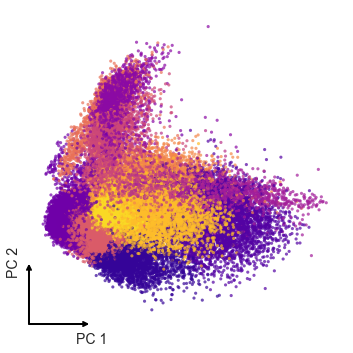

In [8]:
DR_plot(dim_name='PC').plot_IDs(hemato, use_rep='X_pca', obs_col='clusterID', pt_size=10)

In [9]:
%time sc.tl.umap(hemato, random_state=18)

CPU times: user 1min 25s, sys: 4.24 s, total: 1min 30s
Wall time: 1min 7s


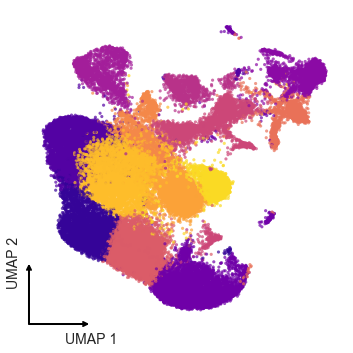

In [10]:
DR_plot(dim_name='UMAP').plot_IDs(hemato, use_rep='X_umap', obs_col='clusterID', pt_size=10, save_to='outputs/hemato_mca_UMAP_clu.png')

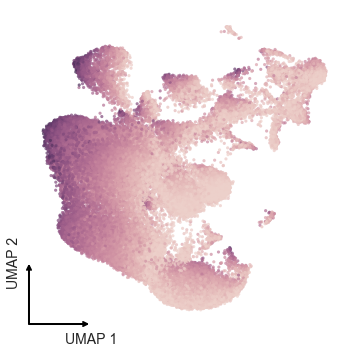

In [11]:
DR_plot(dim_name='UMAP').plot(hemato.obsm['X_umap'], color=hemato.obs['log1p_total_counts'], pt_size=10, save_to='outputs/hemato_mca_UMAP.png')

In [12]:
%time sc.tl.tsne(hemato, random_state=18, perplexity=210, use_rep='X_pca', n_pcs=100)

CPU times: user 10min 45s, sys: 5.83 s, total: 10min 51s
Wall time: 11min


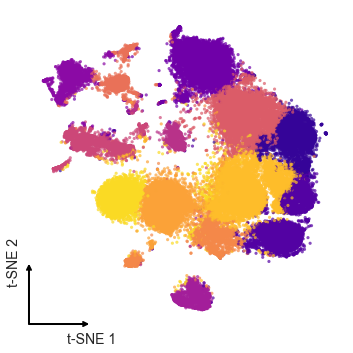

In [13]:
DR_plot(dim_name='t-SNE').plot_IDs(hemato, use_rep='X_tsne', obs_col='clusterID', pt_size=10, save_to='outputs/hemato_mca_tSNE_clu.png')

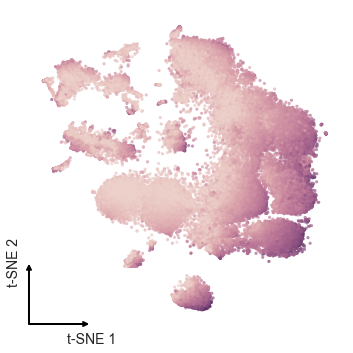

In [14]:
DR_plot(dim_name='t-SNE').plot(hemato.obsm['X_tsne'], color=hemato.obs['log1p_total_counts'], pt_size=10, save_to='outputs/hemato_mca_tSNE.png')

---
### Structural Preservation

In [15]:
%time tSNE_corr, tSNE_EMD, tSNE_knnP = structure_preservation_sc(hemato, latent='X_tsne', native='X_pca', k=30, downsample=49995000)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(tSNE_corr[0],4), round(tSNE_EMD,4), round(tSNE_knnP,4)))

Calculating unique distances for native space, X_pca
Calculating unique distances for latent space, X_tsne
Downsampling to 49995000 total cell-cell distances...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for X_pca
k-nearest neighbor calculation for X_tsne
Determining nearest neighbor preservation

Done!
CPU times: user 4min 10s, sys: 46.6 s, total: 4min 56s
Wall time: 5min 29s
R: 0.5276
EMD: 0.1624
Knn %: 99.8812


CPU times: user 26.1 s, sys: 2.75 s, total: 28.8 s
Wall time: 28.4 s


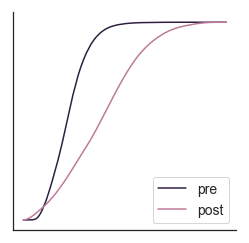

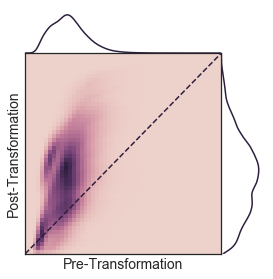

In [16]:
%%time
plt.figure(figsize=(4,4))
plot_cumulative_distributions(hemato.uns['X_pca_norm_distances'], hemato.uns['X_tsne_norm_distances'])
joint_plot_distance_correlation(hemato.uns['X_pca_norm_distances'], hemato.uns['X_tsne_norm_distances'])

In [17]:
%time umap_corr, umap_EMD, umap_knnP = structure_preservation_sc(hemato, latent='X_umap', native='X_pca', k=30, downsample=49995000)
print('R: {}\nEMD: {}\nKnn %: {}'.format(round(umap_corr[0],4), round(umap_EMD,4), round(umap_knnP,4)))

Calculating unique distances for latent space, X_umap
Downsampling to 49995000 total cell-cell distances...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
k-nearest neighbor calculation for X_umap
Determining nearest neighbor preservation

Done!
CPU times: user 2min 55s, sys: 8min 37s, total: 11min 33s
Wall time: 5h 23min 7s
R: 0.5553
EMD: 0.1307
Knn %: 99.8774


CPU times: user 1min 14s, sys: 6.64 s, total: 1min 21s
Wall time: 38min 8s


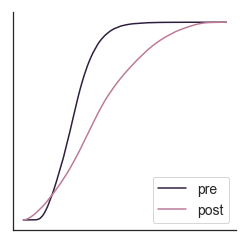

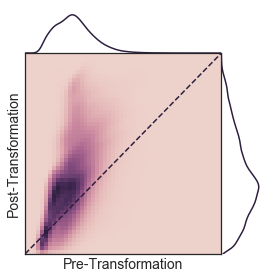

In [18]:
%%time
plt.figure(figsize=(4,4))
plot_cumulative_distributions(hemato.uns['X_pca_norm_distances'], hemato.uns['X_umap_norm_distances'])
joint_plot_distance_correlation(hemato.uns['X_pca_norm_distances'], hemato.uns['X_umap_norm_distances'])